In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import math
import time
import os
import sys
import json

import scipy as sp
from scipy import signal

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from keras.callbacks import EarlyStopping
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import os, warnings, random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras import optimizers, Sequential, Model
from tensorflow.keras.callbacks import LearningRateScheduler

In [2]:
SEED = 13
tf.random.set_seed(SEED)

In [3]:
def encode_gait_percentage(df, name):
  percent = df[name].values.tolist()
  X = np.zeros((len(df[name]),1))
  Y = np.zeros((len(df[name]),1))
  for i in range (len(percent)): 
    phi = percent[i] * 2 * math.pi / 100
    X[i] = math.cos(phi)
    Y[i] = math.sin(phi)
  df['X'] = X
  df['Y'] = Y

In [4]:
def convert_data(d_x, d_y, look_back = 1, fore_cast = 1):
    dataX = []
    dataY = []

    for i in range(look_back, len(d_x) - fore_cast):
        dataX.append(d_x[i - look_back: i]) 
        dataY.append(d_y[i + fore_cast,:])
    
    return np.array(dataX), np.array(dataY)

In [5]:
working_dir = os.getcwd()#os.path.dirname(os.getcwd())
sys_platform = sys.platform
excel_path_dict = {'linux' : "/csvs/", 'win32' : "\Data\Incline\\right_based\SD\\"}
excel_path_name = excel_path_dict[sys_platform]

directory_path = working_dir 
print(directory_path)
excel_path = directory_path + excel_path_name


c:\Users\Admin\Desktop\Neurorobotic Lab\Data_Code\Model\Gait_Phase_Prediction


In [6]:
#inclined_files = ['SKS_2_I.xlsx',  'SKS_3_I.xlsx',  'SKS_4_I.xlsx','SKS_5_I.xlsx', 'SD_2_I.xlsx',  'SD_3_I.xlsx',  'SD_4_I.xlsx','SD_5_I.xlsx']

# Subj TH:
#file_name = ['TH_4_I_r.xlsx', 'TH_2_I_r.xlsx', 'TH_3_I_r.xlsx']

# Subj JJ:
#file_name = ['JJ_4_I.xlsx', 'JJ_6_I.xlsx', 'JJ_7_I.xlsx']
#file_name = ['JJ_4_I_r.xlsx', 'JJ_6_I_r.xlsx', 'JJ_7_I_r.xlsx']

# Subj SD:
file_name = ['SD_1_I_r.xls', 'SD_4_I_r.xls', 'SD_2_I_r.xls', 'SD_3_I_r.xls', 'SD_5_I_r.xls']

# Subj PK:
#file_name = ['PK_0_I_r.xls', 'PK_5_I_r.xls', 'PK_2_I_r.xls', 'PK_3_I_r.xls']

file_list=[]

for i in range (len(file_name)):
    file_list.append(pd.read_excel(excel_path + file_name[i], sheet_name='Sheet1'))

import random
random.shuffle(file_list)

all_data = pd.concat(file_list, axis=0, ignore_index=True)


In [7]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217324 entries, 0 to 217323
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   l_ph_hip      217324 non-null  float64
 1   l_ph_ank      217324 non-null  float64
 2   l_ph_fo       217324 non-null  float64
 3   r_ph_hip      217324 non-null  float64
 4   r_ph_ank      217324 non-null  float64
 5   r_ph_fo       217324 non-null  float64
 6   n_lgrf        217324 non-null  float64
 7   n_r_grf       217324 non-null  float64
 8   n_lcop        217324 non-null  float64
 9   n_rcop        217324 non-null  float64
 10  perc_new      217324 non-null  float64
 11  st_sw_phase   217324 non-null  int64  
 12  strike_frame  217324 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 21.6 MB


In [8]:
cycle = 0
cycle_list = []

start = 0

for i in range(len(all_data) - 1):
    if (all_data['perc_new'][i+1] == 0):
        cycle += 1
        cycle_list.append(all_data.iloc[start:i])
        start = i+1

random.shuffle(cycle_list)
source_table = pd.concat(cycle_list, axis=0, ignore_index=True)

source_table
        

l_ph_hip  l_ph_ank   l_ph_fo  r_ph_hip  r_ph_ank   r_ph_fo    n_lgrf  \
0       0.656802  0.731453  0.974908  0.983959  0.838560  0.728647  0.781459   
1       0.641319  0.731935  0.908082  0.981981  0.829216  0.727334  0.777730   
2       0.620309  0.732268  0.862655  0.979836  0.821819  0.725727  0.772627   
3       0.591357  0.732471  0.833998  0.977493  0.815880  0.723799  0.765905   
4       0.552125  0.732558  0.815289  0.974925  0.811063  0.721511  0.757344   
...          ...       ...       ...       ...       ...       ...       ...   
216121  0.706661  0.727426  0.185960  0.982911  0.089289  0.725414  0.886371   
216122  0.702630  0.729077  0.171631  0.981760  0.045560  0.726169  0.892009   
216123  0.697860  0.730326  0.149616  0.980769  0.995931  0.726404  0.896552   
216124  0.692095  0.731262  0.113242  0.979887  0.948732  0.726221  0.899955   
216125  0.684958  0.731948  0.051879  0.979060  0.910462  0.725679  0.902065   

         n_r_grf    n_lcop    n_rcop   perc_new  st_sw_phase  strike_frame  
0       0.052022  0.000000  0.000068   0.000000            1             1  
1       0.067182  0.000000  0.000311   0.440529            1             2  
2       0.084231  0.000000  0.000605   0.881057            1             3  
3       0.102897  0.000000  0.000955   1.321586            1             4  
4       0.122910  0.000000  0.001365   1.762115            1             5  
...          ...       ...       ...        ...          ...           ...  
216121  0.000000  0.108397 -0.000732  97.142857            0           205  
216122  0.000000  0.109922 -0.000773  97.619048            0           206  
216123  0.000000  0.111365 -0.000802  98.095238            0           207  
216124  0.013739  0.112711 -0.000816  98.571429            0           208  
216125  0.022410  0.113946 -0.000811  99.047619            0           209  

[216126 rows x 13 columns]

In [9]:
source_table = source_table.drop(["n_lgrf","n_r_grf", "l_ph_ank", "r_ph_ank"], axis = 1)
source_table

l_ph_hip   l_ph_fo  r_ph_hip   r_ph_fo    n_lcop    n_rcop   perc_new  \
0       0.656802  0.974908  0.983959  0.728647  0.000000  0.000068   0.000000   
1       0.641319  0.908082  0.981981  0.727334  0.000000  0.000311   0.440529   
2       0.620309  0.862655  0.979836  0.725727  0.000000  0.000605   0.881057   
3       0.591357  0.833998  0.977493  0.723799  0.000000  0.000955   1.321586   
4       0.552125  0.815289  0.974925  0.721511  0.000000  0.001365   1.762115   
...          ...       ...       ...       ...       ...       ...        ...   
216121  0.706661  0.185960  0.982911  0.725414  0.108397 -0.000732  97.142857   
216122  0.702630  0.171631  0.981760  0.726169  0.109922 -0.000773  97.619048   
216123  0.697860  0.149616  0.980769  0.726404  0.111365 -0.000802  98.095238   
216124  0.692095  0.113242  0.979887  0.726221  0.112711 -0.000816  98.571429   
216125  0.684958  0.051879  0.979060  0.725679  0.113946 -0.000811  99.047619   

        st_sw_phase  strike_frame  
0                 1             1  
1                 1             2  
2                 1             3  
3                 1             4  
4                 1             5  
...             ...           ...  
216121            0           205  
216122            0           206  
216123            0           207  
216124            0           208  
216125            0           209  

[216126 rows x 9 columns]

In [10]:
st_sw_idx = len(source_table.columns)
st_sw_idx
source_table.info

<bound method DataFrame.info of         l_ph_hip   l_ph_fo  r_ph_hip   r_ph_fo    n_lcop    n_rcop   perc_new  \
0       0.656802  0.974908  0.983959  0.728647  0.000000  0.000068   0.000000   
1       0.641319  0.908082  0.981981  0.727334  0.000000  0.000311   0.440529   
2       0.620309  0.862655  0.979836  0.725727  0.000000  0.000605   0.881057   
3       0.591357  0.833998  0.977493  0.723799  0.000000  0.000955   1.321586   
4       0.552125  0.815289  0.974925  0.721511  0.000000  0.001365   1.762115   
...          ...       ...       ...       ...       ...       ...        ...   
216121  0.706661  0.185960  0.982911  0.725414  0.108397 -0.000732  97.142857   
216122  0.702630  0.171631  0.981760  0.726169  0.109922 -0.000773  97.619048   
216123  0.697860  0.149616  0.980769  0.726404  0.111365 -0.000802  98.095238   
216124  0.692095  0.113242  0.979887  0.726221  0.112711 -0.000816  98.571429   
216125  0.684958  0.051879  0.979060  0.725679  0.113946 -0.000811  99.047619

In [11]:
x = source_table
x = x.drop(['perc_new'], axis=1)
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled)

encode_gait_percentage(source_table, 'perc_new')
y = source_table[["X","Y"]]
y

data_x = x_scaled


In [12]:
data_y = y.values.reshape(-1,2)

In [13]:
type(data_y)

numpy.ndarray

In [14]:

#data_x,data_y= shuffle_multiple_datasets_based_on_gait_cycle( file_name, excel_path)

X_train, X_test,y_train, y_test = train_test_split(data_x, data_y ,
                        test_size=0.25, 
                        shuffle=False)
look_back = 10
fore_cast = 1

train_x, train_y = convert_data(X_train, y_train, look_back, fore_cast)
validation_x, validation_y = convert_data(X_test, y_test, look_back, fore_cast)


In [15]:
print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)


(162083, 10, 8)
(162083, 2)
(54021, 10, 8)
(54021, 2)


In [16]:
train_x.shape

(162083, 10, 8)

In [17]:
n1=validation_x.shape[0]
val_x=validation_x[1:int(n1/10),:]
val_y=validation_y[1:int(n1/10),:]
print(val_x.shape)
print(val_y.shape)

(5401, 10, 8)
(5401, 2)


In [18]:
def step_decay(epoch):
	initial_lrate = 0.001
	drop = 0.005
	epochs_drop = 10
	lrate=initial_lrate - 0.00001 
	# lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
	return lrate


In [19]:
lr = 0.001
epochs = 20
batch = 128

serie_size = train_x.shape[1]
n_features = train_x.shape[2]
enc_dec_1 = Sequential()
enc_dec_1.add(InputLayer((10, train_x.shape[2])))
enc_dec_1.add(Conv1D(filters=32, kernel_size=3,strides=1,
    activation='relu', padding='same'))            
enc_dec_1.add(AveragePooling1D(pool_size=3))
# enc_dec_1.add(RepeatVector(10))

enc_dec_1.add(LSTM(32,  return_sequences=True))
enc_dec_1.add(LSTM(16,  activation='relu'))
enc_dec_1.add(L.RepeatVector((10)))
enc_dec_1.add(LSTM(16,  return_sequences=True))
enc_dec_1.add(LSTM(32,  activation='relu', return_sequences=True))
enc_dec_1.add(L.TimeDistributed(L.Dense(n_features)))


enc_dec_1.summary()
adam = optimizers.Adam(lr)
enc_dec_1.compile(loss='mse', optimizer=adam)

: 

: 

In [ ]:
encoder_decoder_history = enc_dec_1.fit(train_x, train_x, 
                                              batch_size=batch, 
                                              epochs=epochs, 
                                              verbose=1)

Epoch 1/20
1037/1037 [==============================] - 19s 15ms/step - loss: 0.0336
Epoch 2/20
1037/1037 [==============================] - 11s 11ms/step - loss: 0.0096
Epoch 3/20
1037/1037 [==============================] - 13s 12ms/step - loss: 0.0073
Epoch 4/20
1037/1037 [==============================] - 10s 10ms/step - loss: 0.0061
Epoch 5/20
1037/1037 [==============================] - 12s 11ms/step - loss: 0.0053
Epoch 6/20
1037/1037 [==============================] - 13s 13ms/step - loss: 0.0047
Epoch 7/20
1037/1037 [==============================] - 13s 13ms/step - loss: 0.0041
Epoch 8/20
1037/1037 [==============================] - 10s 9ms/step - loss: 0.0038
Epoch 9/20
1037/1037 [==============================] - 12s 12ms/step - loss: 0.0035
Epoch 10/20
1037/1037 [==============================] - 11s 10ms/step - loss: 0.0032
Epoch 11/20
1037/1037 [==============================] - 16s 16ms/step - loss: 0.0030
Epoch 12/20
1037/1037 [==============================] - 14s 13m

In [ ]:
encoder = Model(inputs=enc_dec_1.inputs, outputs=enc_dec_1.layers[4].output)
train_encoded = encoder.predict(train_x)
validation_encoded = encoder.predict(validation_x)
print('Encoded time-series shape', train_encoded.shape)
print('Encoded time-series sample', train_encoded[0])

1382/1382 [==============================] - 3s 2ms/step
Encoded time-series shape (132668, 10, 16)
Encoded time-series sample [[0.40742466 0.6293527  1.254256   1.559081   1.708854   0.92552096
  0.6872111  1.8210001  0.5892375  1.5377353  1.6156213  0.5114867
  1.5398468  0.34939113 0.7504199  0.2767828 ]
 [0.40742466 0.6293527  1.254256   1.559081   1.708854   0.92552096
  0.6872111  1.8210001  0.5892375  1.5377353  1.6156213  0.5114867
  1.5398468  0.34939113 0.7504199  0.2767828 ]
 [0.40742466 0.6293527  1.254256   1.559081   1.708854   0.92552096
  0.6872111  1.8210001  0.5892375  1.5377353  1.6156213  0.5114867
  1.5398468  0.34939113 0.7504199  0.2767828 ]
 [0.40742466 0.6293527  1.254256   1.559081   1.708854   0.92552096
  0.6872111  1.8210001  0.5892375  1.5377353  1.6156213  0.5114867
  1.5398468  0.34939113 0.7504199  0.2767828 ]
 [0.40742466 0.6293527  1.254256   1.559081   1.708854   0.92552096
  0.6872111  1.8210001  0.5892375  1.5377353  1.6156213  0.5114867
  1.539846

In [ ]:
encoder.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 10, 8)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 10, 32)            800       
                                                                 
 average_pooling1d_3 (Averag  (None, 3, 32)            0         
 ePooling1D)                                                     
                                                                 
 lstm_12 (LSTM)              (None, 3, 32)             8320      
                                                                 
 lstm_13 (LSTM)              (None, 16)                3136      
                                                                 
 repeat_vector_3 (RepeatVect  (None, 10, 16)           0         
 or)                                                       

In [ ]:
mlp_model = Sequential()
# mlp_model.add(InputLayer(()))

mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1]*train_encoded.shape[2])))
# mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=(train_encoded.shape[1])))

mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)
adam = optimizers.Adam(lr_schedule)

mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 32)                5152      
                                                                 
 dense_17 (Dense)            (None, 8)                 264       
                                                                 
 dense_18 (Dense)            (None, 2)                 18        
                                                                 
Total params: 5,434


Trainable params: 5,434
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 50
# lrate = LearningRateScheduler(step_decay)
monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=3, verbose=1, mode='auto')
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))

# train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]))
callback_list = [monitor]
mlp_history = mlp_model.fit(train_encoded_reshaped , train_y, callbacks=callback_list, epochs=epochs, batch_size=batch,  verbose=2)

Epoch 1/50
1037/1037 - 1s - loss: 0.1494 - 1s/epoch - 1ms/step
Epoch 2/50
1037/1037 - 1s - loss: 0.0167 - 1s/epoch - 1ms/step
Epoch 3/50
1037/1037 - 1s - loss: 0.0119 - 1s/epoch - 1ms/step
Epoch 4/50
1037/1037 - 1s - loss: 0.0103 - 1s/epoch - 1ms/step
Epoch 5/50
1037/1037 - 1s - loss: 0.0097 - 1s/epoch - 987us/step
Epoch 6/50
1037/1037 - 2s - loss: 0.0091 - 2s/epoch - 2ms/step
Epoch 7/50
1037/1037 - 1s - loss: 0.0086 - 1s/epoch - 1ms/step
Epoch 8/50
1037/1037 - 1s - loss: 0.0084 - 1s/epoch - 1ms/step
Epoch 9/50
1037/1037 - 1s - loss: 0.0080 - 1s/epoch - 1ms/step
Epoch 10/50
1037/1037 - 1s - loss: 0.0078 - 1s/epoch - 1ms/step
Epoch 11/50
1037/1037 - 1s - loss: 0.0076 - 1s/epoch - 1ms/step
Epoch 12/50
1037/1037 - 1s - loss: 0.0076 - 1s/epoch - 1ms/step
Epoch 13/50
1037/1037 - 1s - loss: 0.0074 - 1s/epoch - 1ms/step
Epoch 14/50
1037/1037 - 1s - loss: 0.0073 - 955ms/epoch - 920us/step
Epoch 15/50
1037/1037 - 1s - loss: 0.0071 - 1s/epoch - 1ms/step
Epoch 16/50
1037/1037 - 1s - loss: 0.0072 

In [ ]:
train_encoded_reshaped=np.reshape(train_encoded,(train_encoded.shape[0], train_encoded.shape[1]*train_encoded.shape[2]))
val_encoded_reshaped=np.reshape(validation_encoded,(validation_encoded.shape[0], validation_encoded.shape[1]*validation_encoded.shape[2]))


In [ ]:
# make predictions
trainPredict = mlp_model.predict(train_encoded_reshaped)
testPredict = mlp_model.predict(val_encoded_reshaped)

   1/4146 [..............................] - ETA: 3:06

1382/1382 [==============================] - 1s 947us/step


In [ ]:

print(trainPredict.shape)
print(testPredict.shape)

(132668, 2)
(44216, 2)


In [ ]:
from sklearn.metrics import mean_squared_error

trainScore = np.sqrt(mean_squared_error(train_y, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(validation_y, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.08 RMSE
Test Score: 0.08 RMSE


In [ ]:
v = X_test[11:]
v.shape

(44216, 8)

In [ ]:
#pred = np.zeros((len(testPredict),1))

#for iter in range(len(testPredict)):
#  x = testPredict[iter][0]
#  y = testPredict[iter][1]
#  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))


x_test = scaler.inverse_transform(v)

pred = np.zeros((len(testPredict),1))

for iter in range(len(testPredict)):
  x = testPredict[iter][0]
  y = testPredict[iter][1]
  pred[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

  
  if ((pred[iter] >= 80) & (x_test[iter][-1] <= 20)) : 
    pred[iter] = pred[iter] - 100  
    if abs(pred[iter]) >= 5:
      pred[iter] = 0 
  

  if ((pred[iter] <= 20) & (x_test[iter][-1] >= 150)):
    pred[iter] = 100 - pred[iter]
    if abs(pred[iter]) >= 5:
        pred[iter] = 100

  

  

  #if (pred[iter] > 100):
  #  pred[iter] = pred[iter] - 100

pred1=pd.DataFrame(pred).sort_index().reset_index()

In [ ]:
actual = np.zeros((len(validation_y),1))

for iter in range(len(validation_y)):
  x =validation_y[iter][0]
  y =validation_y[iter][1]
  actual[iter] = ((math.atan2(y,x) + 2*math.pi) % (2*math.pi)) * (100 / (2*math.pi))

In [ ]:
correct = 0
for i in range(5):
  correct = 0
  for iter in range(len(actual)):
    if (abs(actual[iter] - pred[iter]) <= (i+1)):
      correct+=1

  print(correct)
  print(len(actual))

  print("Precision ", i+1, ": ", correct * 100/len(actual))

22877
44216
Precision  1 :  51.73918943368916
35790
44216
Precision  2 :  80.94354984620952
41277
44216
Precision  3 :  93.35308485616066
43223
44216
Precision  4 :  97.75420662203727
43860
44216
Precision  5 :  99.19486158856523


In [ ]:
perc_rmse = np.sqrt(mean_squared_error(actual, pred))
print("Predicting Percentage RMSE: ", perc_rmse)

Predicting Percentage RMSE:  2.192866875579538


In [ ]:
rmse = 0
length = len(actual)
for i in range(len(actual)):
  if abs (pred[i] - actual[i]) >= 90:
    length -= 1
  else:
    rmse = rmse + pow(pred[i] - actual[i], 2)
rmse = rmse / length
rmse = math.sqrt(rmse)
print(length)
print(len(actual))
print(rmse)

44216
44216
2.1928668755795218


23568
44216


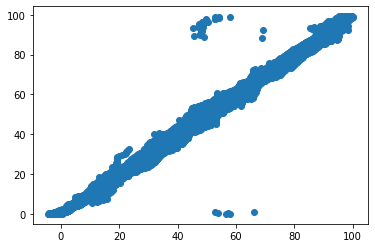

In [ ]:
correct = 0

plt.figure()
plt.scatter(pred, actual)
for iter in range(len(actual)):
  if actual[iter]<2 or actual[iter]>98:
    correct+=1
    continue
  if (abs(actual[iter] - pred[iter]) <= 1):
    correct+=1


print(correct)
print(len(actual))

#print("Precision: ", correct * 100/len(actual))

Text(0.5, 1.0, 'Actual vs Prediction')

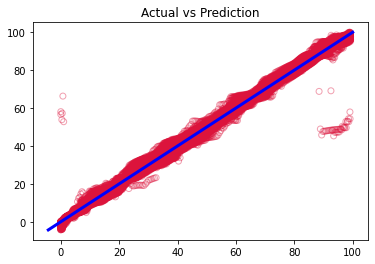

In [ ]:
plt.scatter(actual, pred, facecolors='none', edgecolors='crimson',alpha=0.4)
p1 = max(max(pred), max(actual))
p2 = min(min(pred), min(actual))

ci = 0.1 * np.std([p1,p2]) / np.mean([p1,p2])

plt.plot([p1, p2], [p1, p2], 'b-', linewidth =3)
plt.title('Actual vs Prediction')

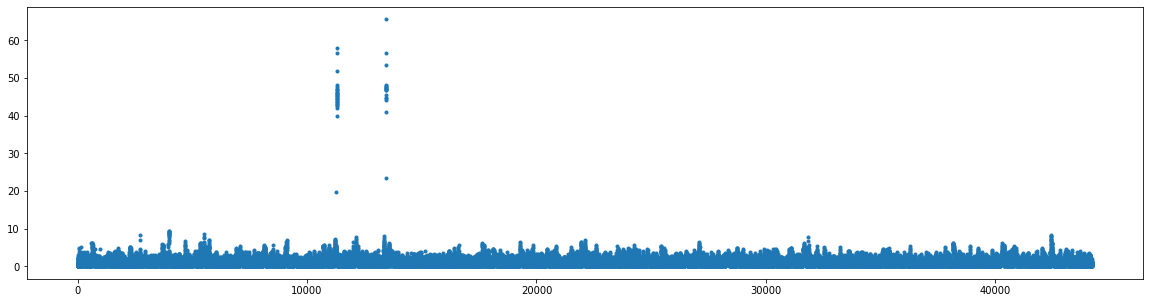

In [ ]:
predfig=plt.figure(figsize=(20,5))
dif = abs(actual-pred)

plt.plot(dif,'.')


In [ ]:
data_dif = pd.DataFrame(pred)
print(data_dif.to_string())

                0
0       13.890575
1       14.409471
2       14.861321
3       16.280326
4       16.308700
5       16.326252
6       16.358896
7       16.416916
8       16.482557
9       16.556502
10      16.638860
11      17.701586
12      18.617769
13      19.699142
14      20.043281
15      20.439555
16      20.989042
17      20.945169
18      22.883279
19      23.019769
20      23.124160
21      23.142900
22      23.281264
23      23.834695
24      24.400261
25      24.975503
26      25.557355
27      26.142448
28      26.727307
29      27.308532
30      27.885288
31      28.452841
32      28.904799
33      29.234509
34      29.550789
35      29.850453
36      30.133000
37      30.398493
38      30.645411
39      30.873262
40      31.087471
41      31.291522
42      31.486171
43      31.672261
44      32.040177
45      31.906959
46      31.581739
47      32.169638
48      34.534512
49      35.612335
50      37.718899
51      38.111567
52      39.185181
53      40.216020
54      40

In [ ]:
act_dif = pd.DataFrame(actual)
print(act_dif.to_string())

               0
0      11.764706
1      12.299465
2      12.834225
3      13.368984
4      13.903743
5      14.438503
6      14.973262
7      15.508021
8      16.042781
9      16.577540
10     17.112299
11     17.647059
12     18.181818
13     18.716578
14     19.251337
15     19.786096
16     20.320856
17     20.855615
18     21.390374
19     21.925134
20     22.459893
21     22.994652
22     23.529412
23     24.064171
24     24.598930
25     25.133690
26     25.668449
27     26.203209
28     26.737968
29     27.272727
30     27.807487
31     28.342246
32     28.877005
33     29.411765
34     29.946524
35     30.481283
36     31.016043
37     31.550802
38     32.085561
39     32.620321
40     33.155080
41     33.689840
42     34.224599
43     34.759358
44     35.294118
45     35.828877
46     36.363636
47     36.898396
48     37.433155
49     37.967914
50     38.502674
51     39.037433
52     39.572193
53     40.106952
54     40.641711
55     41.176471
56     41.711230
57     42.2459

In [ ]:
for i in range(len(pred)):
    if (abs(actual[i]-pred[i]) > 50):
        print(i)

11310
11311
11312
13458
13459
13460


In [ ]:
strike = pd.DataFrame(x_test[:,-1])
print(strike.to_string())

           0
0       23.0
1       24.0
2       25.0
3       26.0
4       27.0
5       28.0
6       29.0
7       30.0
8       31.0
9       32.0
10      33.0
11      34.0
12      35.0
13      36.0
14      37.0
15      38.0
16      39.0
17      40.0
18      41.0
19      42.0
20      43.0
21      44.0
22      45.0
23      46.0
24      47.0
25      48.0
26      49.0
27      50.0
28      51.0
29      52.0
30      53.0
31      54.0
32      55.0
33      56.0
34      57.0
35      58.0
36      59.0
37      60.0
38      61.0
39      62.0
40      63.0
41      64.0
42      65.0
43      66.0
44      67.0
45      68.0
46      69.0
47      70.0
48      71.0
49      72.0
50      73.0
51      74.0
52      75.0
53      76.0
54      77.0
55      78.0
56      79.0
57      80.0
58      81.0
59      82.0
60      83.0
61      84.0
62      85.0
63      86.0
64      87.0
65      88.0
66      89.0
67      90.0
68      91.0
69      92.0
70      93.0
71      94.0
72      95.0
73      96.0
74      97.0
75      98.0

In [ ]:
x_test[18604][:]

array([ 3.64439516e-02,  9.80069041e-01,  5.22209499e-01,  3.37565115e-02,
       -1.37455254e-02, -2.20073160e-03,  0.00000000e+00,  9.10000000e+01])

In [ ]:
print('Predict: ', pred[18604])
print('Actual: ', actual[18604])

Predict:  [42.79615764]
Actual:  [43.68932039]


In [ ]:
#model_save_path="/content/drive/MyDrive/nmchr_lab/models/model_encoder_decoder_MS"

#encoder_decoder.save(model_save_path)

In [ ]:
mlp_model = Sequential()
mlp_model.add(L.Dense(32, kernel_initializer='glorot_normal', activation='relu', input_dim=train_encoded.shape[1]))
mlp_model.add(L.Dense(8, kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(L.Dense(2))
mlp_model.summary()

adam = optimizers.Adam(lr)
mlp_model.compile(loss='mse', optimizer=adam)
lrate = LearningRateScheduler(step_decay)


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 32)                352       
                                                                 
 dense_20 (Dense)            (None, 8)                 264       
                                                                 
 dense_21 (Dense)            (None, 2)                 18        
                                                                 
Total params: 634
Trainable params: 634
Non-trainable params: 0
_________________________________________________________________
